<a href="https://colab.research.google.com/github/suleman12344/Final_YearProject/blob/main/Model/finalYear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y numpy pandas tensorflow

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: pandas 2.2.3
Uninstalling pandas-2.2.3:
  Successfully uninstalled pandas-2.2.3
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0


In [19]:
!pip uninstall -y numpy pandas tensorflow
!pip install numpy==1.24.3 pandas==2.2.2 tensorflow==2.17.0
!pip install torch torchvision opencv-python matplotlib

Found existing installation: numpy 1.24.3
Uninstalling numpy-1.24.3:
  Successfully uninstalled numpy-1.24.3
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
  Using cached numpy-1.24.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached pandas-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
Using cached numpy-1.24.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
Using cached pandas-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (601.3 MB)
ERROR: pip's dependency resolver does not curren

In [1]:
import os
DATASET_PATH = '/content/drive/MyDrive/cubicasa5k'

if os.path.exists(DATASET_PATH):
    print('Dataset exists')
else:
    print('Dataset does not exist')

Dataset exists


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image

class FloorplanDataset(Dataset):
    def __init__(self, txt_file, base_dir, transform=None):
        """
        Args:
            txt_file (str): Path to the text file (e.g., train.txt).
            base_dir (str): Path to the base directory (e.g., high_quality).
            transform (callable, optional): Transform to apply to the images.
        """
        self.base_dir = base_dir
        self.transform = transform

        # Read the text file and generate a list of all image paths
        with open(txt_file, 'r') as file:
            folders = [line.strip() for line in file.readlines()]

        self.image_files = []
        for folder in folders:
            folder_path = base_dir+folder#os.path.join(base_dir, folder)
            self.image_files += [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [3]:
train_path = "/content/drive/MyDrive/cubicasa5k/train.txt"
train_dataset = FloorplanDataset(txt_file=train_path, base_dir=DATASET_PATH, transform=transform)
test_path = "/content/drive/MyDrive/cubicasa5k/test.txt"
test_dataset = FloorplanDataset(txt_file=test_path, base_dir=DATASET_PATH, transform=transform)
val_path = "/content/drive/MyDrive/cubicasa5k/val.txt"
val_dataset = FloorplanDataset(txt_file=val_path, base_dir=DATASET_PATH, transform=transform)

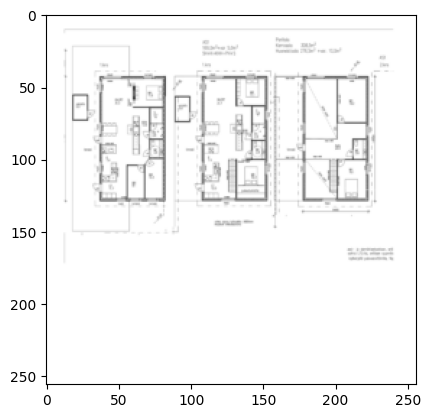

In [4]:
from matplotlib import pyplot as plt

sample_image = train_dataset[0]  # Get the first image
plt.imshow(sample_image.permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize for visualization
plt.show()

In [5]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.main = nn.Sequential(
            # Input is latent_dim
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            # State size: 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # State size: 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # State size: 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # State size: 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # Input is 3 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)